In [1]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from tqdm import tqdm
from langchain_openai import AzureOpenAIEmbeddings
import json
import numpy as np
import torch
import time
import random
import ast
import matplotlib.pyplot as plt
import os

Let's fetch the dataframes.

In [10]:
from data_extractor import Extractor

extractor_instance = Extractor()
extractor_instance.extract(location="./data/results/df_combined.csv")  # This saves the CSV

# Load the saved CSV
df_combined = pd.read_csv("./data/results/df_combined.csv")

# Now filter for innovations only for similarity comparison
innovations_only = df_combined[df_combined["source type"] == "Innovation"].copy()
print(f"Total relationships: {len(df_combined)}")
print(f"Innovation relationships only: {len(innovations_only)}")

Comp domain df length: 1912  - VTT domain df length: 4927
Example of text to compare: FiR 1 - FiR 1 is a Triga-type nuclear research reactor located in Otaniemi, Espoo, Finland, decommissioned by VTT after serving since 1962, used for nuclear research, training, and medical radiation therapy. | Developed by VTT Technical Research Centre of Finland Ltd.
Total relationships: 6839
Innovation relationships only: 6767


In [11]:
from embedding_generator import EmbeddingGenerator, OpenAIEmbeddingProvider
import ast
import os

# Configuration
METHOD = "openai"
MODEL_KEY = "gpt-4.1-mini"

# Create temporary file for innovations only
innovations_file = "data/results/innovations_for_similarity.csv"
innovations_only.to_csv(innovations_file, index=False)

# Generate embeddings for innovations only
output_file = "data/results/innovations_embeddings.csv"
provider = OpenAIEmbeddingProvider(MODEL_KEY)
generator = EmbeddingGenerator(provider)

if os.path.exists(output_file):
    innovations_with_embeddings = pd.read_csv(output_file)
    print(f"Loaded {len(innovations_with_embeddings)} innovation embeddings")
else:
    innovations_with_embeddings = generator.generate_embeddings(innovations_file, output_file)

# Convert embeddings from string to list
innovations_with_embeddings["embedding"] = innovations_with_embeddings["embedding"].apply(ast.literal_eval)

2025-05-31 16:46:15,787 - INFO - Initialized OpenAI embedding model with key: gpt-4.1-mini
2025-05-31 16:46:15,787 - INFO - Loading data from data/results/innovations_for_similarity.csv
2025-05-31 16:46:16,216 - INFO - Loaded 6767 rows from input file
2025-05-31 16:46:16,217 - INFO - Prepared 6767 texts for embedding generation
2025-05-31 16:46:16,217 - INFO - Generating embeddings for 6767 texts using OpenAI API
Processing batches:  71%|███████   | 48/68 [05:23<01:08,  3.42s/it]2025-05-31 16:51:40,365 - INFO - HTTP Request: POST https://aaltoaihack25-resource.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-12-01-preview "HTTP/1.1 429 Too Many Requests"
2025-05-31 16:51:40,366 - INFO - Retrying request to /embeddings in 1.000000 seconds
2025-05-31 16:51:41,980 - INFO - HTTP Request: POST https://aaltoaihack25-resource.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-12-01-preview "HTTP/1.

ValueError: malformed node or string: [-0.018910497426986694, 0.017533520236611366, -0.021128961816430092, -0.028319846838712692, -0.0452260747551918, -0.0024670856073498726, -0.020302774384617805, 0.028870638459920883, -0.004433103837072849, 0.0174111220985651, 0.0007936747861094773, -0.00169827276840806, -0.010526231490075588, 0.0004487131373025477, -0.0018589202081784606, 0.029972219839692116, 0.010541531257331371, -0.040085356682538986, -0.020991263911128044, -0.035526029765605927, 0.046480655670166016, -0.008843258023262024, -0.019109394401311874, -0.03219068422913551, -0.0032473730389028788, -0.008613762445747852, -0.046174660325050354, 0.001806327374652028, -0.03396545723080635, 0.008040021173655987, 0.01184966042637825, 0.04467528313398361, -0.04262511804699898, -0.016936829313635826, 0.018619801849126816, -0.01063332986086607, 0.0033353467006236315, 0.009080404415726662, 0.04409389570355415, 0.018528003245592117, 0.0029337280429899693, -0.004096509423106909, -0.013356686569750309, 0.03323106840252876, 0.009187502786517143, 0.009554697200655937, -0.0016648046439513564, -0.038402386009693146, 0.013043041341006756, -0.010518581606447697, 0.027126464992761612, 0.016248339787125587, -0.0014123586006462574, 0.03922857344150543, 0.03258847817778587, 0.013846278190612793, 0.021052462980151176, 0.11413617432117462, 0.0002933249925263226, -0.027355961501598358, -0.00407738471403718, -0.036658212542533875, -0.007917623035609722, -0.006716592703014612, 0.013555582612752914, 0.0352812334895134, 0.023072030395269394, -0.006796916015446186, -0.06652333587408066, 0.00658271973952651, -0.01973668485879898, -0.023225028067827225, -0.009975439868867397, -0.0028476668521761894, -0.03476104512810707, -0.022444739937782288, 0.00971534475684166, 0.0031823490280658007, 0.047521039843559265, -0.016370737925171852, 0.02226114273071289, 0.020394572988152504, -0.02226114273071289, 0.02285783365368843, -0.030553610995411873, 0.02339332550764084, -0.03693360835313797, -0.058230869472026825, -0.02177155204117298, 0.005247815977782011, -0.021450256928801537, 0.06805331259965897, -0.0027195315342396498, 0.04078914597630501, 0.007076136767864227, 0.011979708448052406, 0.008782058954238892, -0.025917785242199898, -0.0007066574180498719, 0.05474252253770828, -0.004601401276886463, -0.0034405323676764965, -0.011222369968891144, 0.02102186344563961, -0.014542417600750923, -0.017273424193263054, -0.04718444496393204, 0.04810243099927902, 0.03763739764690399, 0.09032975137233734, -0.01179611124098301, -0.025443492457270622, -0.015330354683101177, -0.03163989260792732, 0.030721908435225487, 0.019216492772102356, 0.024571405723690987, -0.024800902232527733, -0.01023553591221571, -0.030874906107783318, -0.024724403396248817, -0.013394935987889767, 0.015039659105241299, 0.009049804881215096, -0.03280267491936684, 0.015529251657426357, 0.02137375809252262, -0.021557355299592018, 0.0308902058750391, 0.026942867785692215, -0.021924549713730812, -0.030415913090109825, 0.02239884063601494, -0.05321254953742027, 0.037606798112392426, -0.00795587245374918, -0.007114386186003685, 0.009439948946237564, 0.007259733974933624, 0.005657084286212921, 0.0004721408768091351, 0.007531304378062487, -0.008544913493096828, -0.006142851430922747, -0.02821274846792221, 0.0010652454802766442, -0.05538511276245117, 0.042563918977975845, 0.032251883298158646, -0.024127714335918427, -0.03167049214243889, 0.017043927684426308, -0.008284817449748516, 0.013708580285310745, -0.015475702472031116, -0.027554858475923538, 0.011490115895867348, 0.03277207538485527, -0.011436566710472107, -0.003400370478630066, -0.04547087103128433, 0.004815598018467426, -0.0014573016669601202, -0.023959416896104813, -0.047765836119651794, 0.02161855436861515, 0.01823730766773224, 0.003243548097088933, -0.006506220903247595, -0.0004678378172684461, 0.003364033531397581, -0.01098522450774908, 0.012744695879518986, 0.02111366204917431, -0.000381537654902786, 0.011719612404704094, -0.026560375466942787, 0.005905705504119396, 0.011880259960889816, -0.0389837771654129, -0.03341466560959816, 0.03622981905937195, 0.027876153588294983, 0.012155655771493912, -0.004069734830409288, 0.035862624645233154, 0.030324114486575127, -0.009279301390051842, 0.012216854840517044, -0.01719692535698414, 0.035862624645233154, -0.004020010586827993, 0.03987115994095802, 0.0494794063270092, 0.025703588500618935, 0.009325200691819191, -0.0017164412420243025, 0.016294239088892937, 0.03258847817778587, -0.006070178002119064, 0.0045631518587470055, 0.024081815034151077, -0.026101382449269295, 0.03316986933350563, -0.04932640865445137, 0.007753151003271341, 0.07099086046218872, -0.008789708837866783, 0.029620325192809105, 0.0014429581351578236, 0.016523735597729683, -0.035464830696582794, 0.032649677246809006, -0.012484599836170673, -0.01479486282914877, -0.002857229206711054, -0.00927165150642395, 0.010006039403378963, -0.018879897892475128, 0.006506220903247595, 0.009378749877214432, 0.017043927684426308, 0.02102186344563961, 0.012339252047240734, -0.014940210618078709, -0.016569634899497032, -0.03950396925210953, -0.014588316902518272, -0.015054958872497082, 0.014014575630426407, -0.010901075787842274, 0.060464631766080856, 0.01779361441731453, 0.004960945807397366, -0.026392078027129173, 0.04681725054979324, -0.007799050305038691, -0.03638281673192978, 0.007079961709678173, 0.021832751110196114, -0.029237832874059677, 0.04794943332672119, -0.026514476165175438, -0.006498571019619703, 0.006674518343061209, 0.012017957866191864, -0.047215044498443604, 0.03604622185230255, -0.03044651262462139, 0.0009203758672811091, -0.02761605754494667, -0.009623546153306961, 0.014351170510053635, 0.007202359847724438, -0.03084430657327175, 0.0185433030128479, -0.0006062528118491173, 0.0215726550668478, -0.017043927684426308, 0.03748439997434616, -0.007026412524282932, 0.0007080917712301016, 0.02330152690410614, 0.00455932691693306, -0.0414317362010479, 0.0014228771906346083, -0.02463260479271412, -0.03365946188569069, -0.00754660414531827, -0.02790675312280655, 0.02825864776968956, 0.010610380209982395, 0.025795387104153633, -0.0014324395451694727, 0.03895317763090134, -0.003601179923862219, -0.009447598829865456, 0.058230869472026825, -0.016248339787125587, 0.017625316977500916, -0.008988605812191963, 0.017380522564053535, 0.020012078806757927, -0.03277207538485527, -0.021450256928801537, -0.030324114486575127, -0.0129129933193326, 0.0036528166383504868, 0.00415005860850215, -0.02841164544224739, -0.005924830213189125, -0.02146555669605732, -0.018176108598709106, 0.008062970824539661, 0.0026545075234025717, -0.0143817700445652, 0.034975241869688034, -0.034179653972387314, 0.006150501314550638, 0.008881507441401482, -0.02622378058731556, 0.023378025740385056, -0.0023886743001639843, -0.02082296647131443, -0.027554858475923538, -0.02365342155098915, 0.017931312322616577, 0.027845554053783417, -0.026147281751036644, 0.018160808831453323, -0.0033869831822812557, -0.033843059092760086, -0.031609293073415756, -0.05749648064374924, 0.0036948907654732466, -0.03818818926811218, -0.054711923003196716, -0.024204213172197342, 0.012836494483053684, -0.006934613920748234, 0.009975439868867397, -0.03607682138681412, -0.057833075523376465, 0.027478359639644623, 0.06670693308115005, -0.034087855368852615, 0.036903008818626404, 0.0006684080581180751, 0.01918589323759079, 0.0071067363023757935, 0.056547895073890686, -0.013838628306984901, -0.029773322865366936, -0.0215726550668478, -0.026851071044802666, -0.02856464311480522, -0.06401417404413223, -0.01858920231461525, -0.016967428848147392, 0.010403833352029324, -0.01606474258005619, 0.0009787061717361212, 0.033047471195459366, 0.005045094061642885, -0.029130734503269196, -0.018803399056196213, -0.004287756513804197, -0.001333947409875691, -0.01256874855607748, 0.025917785242199898, 0.000769290782045573, -0.019644886255264282, 0.03255787864327431, -0.03396545723080635, 0.04063614830374718, -0.013762129470705986, -0.0015997806331142783, -0.009830093011260033, 0.042410921305418015, 0.024081815034151077, -0.0034405323676764965, -0.010801627300679684, 0.019262392073869705, -0.0026755447033792734, -0.014680114574730396, 0.017334623262286186, -0.0029490278102457523, -0.0026602449361234903, 0.03806579113006592, 0.02429601177573204, -0.008193018846213818, 0.021679753437638283, 0.0113524179905653, -0.0009007730986922979, 0.007060837000608444, -0.04718444496393204, -0.013234288431704044, -0.009562347084283829, 0.019017595797777176, 0.0009194196318276227, -0.0015146757941693068, -0.001495551085099578, -0.010457382537424564, 0.013792729005217552, 0.028641141951084137, 0.010181986726820469, 0.042655717581510544, -0.04556266963481903, -0.06627853959798813, 0.0012038995046168566, 0.024969199672341347, -0.005813906900584698, 0.0008132776129059494, 0.004421629011631012, -0.0036203046329319477, -0.010602730326354504, -0.019996779039502144, -0.01296654250472784, 0.03176229074597359, -0.02587188594043255, -0.01586584560573101, -0.0016351613448932767, -0.05275355651974678, 0.006085477769374847, -0.04596046358346939, 0.005435238126665354, -0.044583484530448914, -0.00536638917401433, -0.017028627917170525, 0.030905505642294884, 0.010595080442726612, -0.006429722066968679, 0.02626967988908291, -0.019048195332288742, 0.010954624973237514, -0.013020091690123081, 0.00574888288974762, -0.03133389726281166, -0.016386037692427635, -0.022001048550009727, -0.010717478580772877, 0.04547087103128433, 0.0044637033715844154, 0.035036440938711166, 0.012721746228635311, 0.04293111339211464, 0.003276060102507472, -0.004494302906095982, 0.020195676013827324, -0.04219672456383705, -0.023179128766059875, -0.029314329847693443, 0.02741716057062149, 0.015927044674754143, 0.01023553591221571, -0.005255465861409903, 0.05397753417491913, 0.0696444883942604, -0.030920805409550667, 0.03638281673192978, -0.017441721633076668, 0.013272537849843502, 0.00774550111964345, 0.0027616058941930532, -0.005569110624492168, 0.011727262288331985, 0.012323952279984951, -0.007810525130480528, 0.038004592061042786, 0.01839030534029007, 0.048561424016952515, 0.00015431237989105284, -0.0057182833552360535, -0.006617144215852022, -0.005871281027793884, 0.01003663893789053, 0.035617828369140625, 0.0007358225993812084, 0.03589322417974472, -0.01670733280479908, 0.0030465638265013695, 0.030920805409550667, -0.002822804730385542, -0.014672464691102505, 0.004555501975119114, -0.005259290803223848, -0.012997142039239407, -0.041125740855932236, 0.00901920534670353, 0.014213472604751587, 0.01241575088351965, 0.006854290142655373, -0.016692033037543297, 0.0432371087372303, 0.008246568031609058, -0.02122076041996479, -0.01383097842335701, -0.0022643636912107468, -0.015238556079566479, -0.06028103455901146, 0.03069130890071392, -0.000599081045947969, -0.002394411712884903, 0.0206699687987566, 0.003905262565240264, 0.027386561036109924, 0.03858598321676254, -0.0031211499590426683, 0.02405121549963951, 0.013555582612752914, 0.02265893667936325, -0.018007811158895493, -0.023087330162525177, 0.0028973910957574844, -0.014718363992869854, -0.014251722022891045, -0.008935056626796722, -0.007741676177829504, -0.02053227089345455, -0.04681725054979324, 0.030201716348528862, 0.009753594174981117, 0.01929299160838127, 0.023378025740385056, -0.016539035364985466, 0.028472844511270523, 0.02013447694480419, -0.003484519198536873, -0.01009018812328577, 0.007669002283364534, -0.007577203679829836, 0.004371905233711004, -0.05532391369342804, 0.010526231490075588, 0.018329106271266937, 0.012140356004238129, -0.017181625589728355, -0.024372510612010956, 0.010901075787842274, 0.00024156879226211458, 0.040177155286073685, -0.009791843593120575, -0.000935197516810149, 0.010717478580772877, -0.00312879984267056, -0.006028103642165661, -0.017441721633076668, -0.01759471744298935, 0.02815154939889908, 0.010067238472402096, 0.02518339641392231, 0.012859444133937359, 0.02548939175903797, -0.004968595691025257, 0.02186335064470768, 0.011956758797168732, -0.03332286700606346, 0.01363208144903183, 0.004742924124002457, -0.03834118694067001, -0.04189072921872139, -0.032007087022066116, -0.004582276567816734, 0.013043041341006756, 0.0016007368685677648, 0.03219068422913551, 0.01661553420126438, 0.0020482547115534544, -0.01566694863140583, 0.027478359639644623, 0.007948222570121288, 0.039932359009981155, 0.0053396145813167095, 0.010556831024587154, 0.00901920534670353, 0.04366550222039223, 0.03148689493536949, -0.03580142557621002, -0.004295406397432089, -0.003518943674862385, 0.02697346732020378, 0.01452711783349514, -0.02007327787578106, -0.005672384053468704, -0.0036815034691244364, 0.012255104258656502, -0.003954986575990915, -0.005003019701689482, -0.0175029207020998, -0.003189998911693692, 0.022964932024478912, -0.0332004688680172, 0.006376172881573439, -0.003159399377182126, -0.003754177363589406, 0.00036408635787665844, -0.05281475558876991, -0.042410921305418015, -0.017135726287961006, -0.004643475636839867, 0.02197044901549816, -0.038096390664577484, -0.030415913090109825, 0.0267286729067564, -0.0021649154368788004, 0.007665177341550589, 0.009906591847538948, 0.020792366936802864, 0.004012360703200102, -0.019323591142892838, -0.01383097842335701, -0.00825421791523695, 0.015131457708775997, -0.0047964733093976974, -0.019002296030521393, -0.017319323495030403, -0.009898941963911057, 0.02320972830057144, 0.027401860803365707, -0.048959217965602875, -0.024280712008476257, 0.007691951934248209, -0.018956396728754044, -0.04060554876923561, 0.011520715430378914, 0.01913999393582344, 0.014121674001216888, -0.016921529546380043, -0.02071586810052395, 0.023684021085500717, 0.02578008733689785, -0.03742320090532303, 0.01874219998717308, 0.01947658881545067, 0.03219068422913551, 0.04372670128941536, 0.01418287307024002, 0.019201193004846573, -0.025810686871409416, -0.0023676371201872826, 0.0413399375975132, -0.005381688941270113, 0.026009583845734596, 0.030002819374203682, -0.005060393828898668, 0.005213391501456499, 0.006804565899074078, 0.006877239793539047, -0.021649153903126717, -0.0013463784707710147, 0.031701091676950455, 0.013341386802494526, 0.010725128464400768, -0.014397069811820984, -0.025519991293549538, -0.018681000918149948, 0.030415913090109825, -0.006142851430922747, 0.021251359954476357, -0.024617305025458336, 0.04155413433909416, -0.02007327787578106, -0.009187502786517143, -0.0019985304679721594, -0.0068389903753995895, -0.019247092306613922, 0.01967548578977585, 0.002262451220303774, 0.0009877904085442424, 0.00397793622687459, -0.008728510700166225, 0.017564117908477783, 0.03277207538485527, 0.018130209296941757, 0.003947336692363024, -0.04798003286123276, 0.012025607749819756, -0.030308814719319344, -0.015422153286635876, -0.018252607434988022, 0.013004791922867298, 0.02861054241657257, 0.014343520626425743, -0.016768531873822212, -0.004180658143013716, -0.02091476507484913, -0.003515118733048439, -0.015881145372986794, -0.007210009731352329, 0.005232516210526228, 0.0003934905689675361, -0.012943592853844166, -0.0021496156696230173, -0.008736160583794117, 0.023684021085500717, -0.01209445670247078, 0.015621050260961056, 0.05036679282784462, -0.00785642396658659, -0.005481137428432703, -0.012981842271983624, 0.005048919003456831, -0.011857310310006142, 0.003430970013141632, 0.014833112247288227, -0.004918871447443962, 0.013693280518054962, -0.0008591768564656377, -0.03543423116207123, -0.012499899603426456, -0.012974192388355732, -0.011880259960889816, -0.0068236906081438065, 0.019002296030521393, 0.004127108957618475, -0.011459516361355782, -0.014986109919846058, -0.011528365314006805, 0.00247856043279171, -0.012484599836170673, -0.024816201999783516, -0.011964408680796623, -0.007657527457922697, -0.014611266553401947, 0.012828844599425793, -0.029084835201501846, -0.017763014882802963, -0.033139269798994064, 0.007110561244189739, 0.006598019506782293, 0.004046785179525614, -0.028289247304201126, 0.014305271208286285, 0.0064564966596663, -0.031609293073415756, -0.004287756513804197, -0.004517252556979656, 0.008116520009934902, 0.011780811473727226, 0.006731892004609108, 0.012109756469726562, 0.02469380386173725, -0.023668721318244934, -0.025810686871409416, 0.034179653972387314, -0.019400089979171753, 0.004291581455618143, 0.02091476507484913, -0.02717236429452896, 0.0068236906081438065, 0.006441196892410517, 0.013938076794147491, -0.0009657970513217151, 0.010465032421052456, -0.038494184613227844, 0.041523534804582596, -0.03974876552820206, 0.006946088746190071, 0.0074509805999696255, 0.005936305038630962, 0.03675001114606857, -0.012538149021565914, -0.002614345634356141, 0.0018197146710008383, -0.044246893376111984, -0.017426421865820885, -0.027738455682992935, -0.004991544876247644, -0.006571244914084673, 0.008766760118305683, 0.008896807208657265, 0.0038306761998683214, 0.005955429747700691, -0.02677457220852375, 0.0023313001729547977, -0.014802512712776661, 0.04167653247714043, -0.030079318210482597, 0.012278053909540176, -0.02131255902349949, -0.003413757774978876, 0.03476104512810707, 0.02850344404578209, -0.018619801849126816, 0.016340138390660286, -0.032894473522901535, -0.007045537233352661, -0.027876153588294983, 0.014511818066239357, -0.014955510385334492, 0.04510367661714554, 0.002700406825169921, 0.03387365862727165, -0.031150301918387413, -0.0005938217509537935, -0.014420019462704659, -0.020562870427966118, 0.015338004566729069, 0.0037771270144730806, -0.030217016115784645, -0.02146555669605732, -0.05315135046839714, -0.013647381216287613, -0.03984056040644646, -0.0012794419890269637, -0.0247397031635046, 0.009592946618795395, 0.02385231852531433, 0.03831058740615845, 0.03766799718141556, 0.03476104512810707, 0.0051407176069915295, 0.001426702132448554, 0.015100858174264431, 0.019078794866800308, 0.02385231852531433, -0.01759471744298935, -0.007340057287365198, -0.029681524261832237, -0.019797883927822113, 0.023714620620012283, 0.02880943939089775, 0.02062406949698925, 0.023316826671361923, -0.029635624960064888, 0.0044637033715844154, 0.0004996326169930398, -0.0237911194562912, -0.019323591142892838, 0.017166325822472572, 0.01913999393582344, 0.02181745134294033, 0.035617828369140625, 0.02781495451927185, 0.005691508762538433, -0.012186255306005478, 0.004195957910269499, -0.015077908523380756, -0.01858920231461525, -0.013739179819822311, 0.008950356394052505, -0.011903209611773491, 0.012377501465380192, -0.010266135446727276, -0.01326488796621561, 0.008774409070611, -0.009286951273679733, -0.02602488361299038, -0.005484962370246649, -0.008950356394052505, -0.0289471372961998, 0.04418569430708885, 0.03203768655657768, -0.026988767087459564, 0.000879257800988853, -0.008529613725841045, -0.007133510895073414, 0.01119942031800747, -0.026805171743035316, 0.036903008818626404, -0.010220236144959927, -0.010839876718819141, -0.019461289048194885, -0.0045134276151657104, -0.0298957210034132, -0.022276442497968674, -0.0068887146189808846, -0.006770141422748566, 3.0659273761557415e-05, -0.002023392589762807, 0.019109394401311874, -0.036566413938999176, 0.007320932578295469, 0.02958972565829754, -0.009623546153306961, 0.009692395105957985, -0.0023886743001639843, -0.0023504248820245266, 0.0016342051094397902, -0.020608769729733467, 0.0038651006761938334, 0.007994121871888638, 0.0328332744538784, 0.0196295864880085, -0.03108910284936428, 0.0016523735830560327, -0.011757861822843552, 0.009088054299354553, -0.024525508284568787, 0.004433103837072849, -0.0016600234666839242, -0.02766195684671402, 0.01159721426665783, -0.00010512604785617441, -0.007932922802865505, -0.012461650185286999, 0.005760357715189457, 0.016783831641077995, 0.01261464785784483, 0.04690904915332794, 0.015628699213266373, 0.04782703518867493, -0.03212948516011238, 0.02538229338824749, -0.0175029207020998, 0.03206828609108925, 0.0015682248631492257, 0.010579780675470829, 0.03219068422913551, -0.024326611310243607, -0.011719612404704094, 0.015942344442009926, -0.01571284793317318, -0.01823730766773224, -8.217641880037263e-05, 0.024877401068806648, 0.037606798112392426, 0.03812699019908905, 0.0004487131373025477, 0.00016196224896702915, -0.009738294407725334, -0.008629062213003635, 0.0006048184586688876, 0.025106897577643394, 0.005611184984445572, -0.0013157789362594485, -0.025718888267874718, -0.010870476253330708, -0.018726900219917297, 0.014917260967195034, -0.01814550906419754, 0.0073515321128070354, 0.02339332550764084, -0.00014140320126898587, 0.0028916536830365658, -0.023240327835083008, -0.007986471988260746, 0.018573902547359467, -0.006376172881573439, 0.02880943939089775, -0.01630953885614872, 0.0031842614989727736, -0.03375126048922539, -0.029605025425553322, -0.010480332188308239, -0.00860611256211996, 0.0015309317968785763, -0.00037101906491443515, 0.009937191382050514, 0.007986471988260746, -0.0016772357048466802, 0.01913999393582344, -0.0013798467116430402, 0.009348150342702866, 0.006219350267201662, 0.008950356394052505, 0.004215082619339228, 0.0004616222868207842, 0.031854089349508286, -0.04039135202765465, 0.001747997011989355, 0.034638646990060806, 0.03375126048922539, -0.02418891340494156, 0.021832751110196114, 0.01353263296186924, 0.019002296030521393, -0.010197286494076252, -0.015552201308310032, 0.010480332188308239, -0.005936305038630962, -0.045685067772865295, -0.03163989260792732, -0.002021480118855834, -0.015598100610077381, -0.03122680075466633, -0.01739582233130932, -0.03733140230178833, 0.02726416289806366, 0.010855176486074924, -0.008460764773190022, -0.011413617059588432, 0.0035093813203275204, 0.0019000383326783776, -0.0025550590362399817, 0.024647904559969902, -0.002612433163449168, 0.008935056626796722, -0.008858557790517807, 0.00012622297799680382, -0.023913517594337463, 0.0050909933634102345, 0.030125217512249947, 0.004651125520467758, 0.0064450218342244625, 0.011857310310006142, -0.023638121783733368, 0.0041844830848276615, 0.0033181344624608755, 0.0331086702644825, 0.0473068431019783, 0.021083062514662743, 0.010250835679471493, -0.027325361967086792, -0.024035915732383728, 0.021802151575684547, -0.035709626972675323, -0.01009018812328577, -0.010044288821518421, -0.018329106271266937, -0.004807948134839535, -0.005855981260538101, 0.006123727187514305, -0.003962636459618807, 0.017288723960518837, 0.005890405736863613, -0.004888271912932396, -0.014343520626425743, 0.0004116590425837785, 0.01701332814991474, 0.015024359337985516, -0.017763014882802963, 0.02062406949698925, -0.012928293086588383, -0.04914281144738197, 0.01363208144903183, -0.024372510612010956, 0.014879011549055576, 0.014986109919846058, 0.04865322262048721, 0.0013415972935035825, 0.02721826359629631, 0.019996779039502144, -0.002767343306913972, 0.037056006491184235, -0.019522488117218018, 0.027891453355550766, 0.007099086418747902, 0.01241575088351965, 0.021083062514662743, -0.010916375555098057, 0.010977574624121189, 0.009906591847538948, -0.01412932388484478, -0.004876797087490559, 0.04443049058318138, -0.036505214869976044, 0.025244595482945442, 0.03595442324876785, -0.003465394489467144, 0.005316664930433035, -0.013104240410029888, 0.00213814084418118, -0.01023553591221571, 0.02726416289806366, -0.006188750732690096, -0.010006039403378963, -0.034730445593595505, 0.007810525130480528, -0.0008132776129059494, -0.009241051971912384, 0.007508354727178812, 0.0063608731143176556, 0.010824576951563358, 0.002187865087762475, -0.02608608268201351, -0.022031648084521294, -0.011681362986564636, -0.006119902245700359, -0.005201916676014662, -0.014504168182611465, -0.006881064735352993, 0.0247397031635046, 0.01894109696149826, 0.010572130791842937, 0.02086886577308178, -0.03834118694067001, 0.029972219839692116, 0.011329468339681625, -0.015972943976521492, -0.0011197507847100496, 0.006716592703014612, 0.016845030710101128, 0.01927769184112549, 0.013876877725124359, 0.018849298357963562, 0.0007272164802998304, 0.012706446461379528, 0.006460321601480246, -0.021098362281918526, 0.010778677649796009, 0.021587954834103584, 0.009164553135633469, 0.021343158558011055, -0.01368563063442707, 0.033843059092760086, -0.031854089349508286, -0.0010461207712069154, 0.009944840334355831, 0.015338004566729069, -0.00042050419142469764, 0.047521039843559265, -0.004670250229537487, 0.022827234119176865, 0.002480472903698683, 0.017242824658751488, 0.00010626157745718956, -0.008682611398398876, 0.016248339787125587, 0.02042517252266407, -0.0052898903377354145, 0.004815598018467426, 0.017671216279268265, 0.023362725973129272, 0.00577565748244524, 0.02399001643061638, 0.0018971696263179183, 0.039197973906993866, 0.0056341346353292465, -0.0021840401459485292, -0.009485848248004913, 0.007676652166992426, 0.006532995495945215, 0.008430165238678455, -0.001825452083721757, 0.02117486111819744, 0.015942344442009926, 0.0071220360696315765, 0.007489230018109083, -0.011933809146285057, 0.004544027149677277, 0.0061007775366306305, 0.005626484751701355, -0.012285702861845493, 0.006961388513445854, -0.032649677246809006, -0.005691508762538433, 0.04103394225239754, -0.006391472648829222, -0.0018025024328380823, 0.010801627300679684, 0.009179852902889252, -0.021144261583685875, 0.014366470277309418, 0.0003681503585539758, -0.015567501075565815, -0.007370656821876764, 0.011275919154286385, -0.008193018846213818, -0.004949470981955528, 0.004769698716700077, 0.0021113662514835596, 0.0227966345846653, -0.010541531257331371, 0.03405725583434105, 0.03494464233517647, 0.005986029282212257, -0.02429601177573204, -0.0009653189335949719, 0.012262754142284393, -0.019797883927822113, -0.01661553420126438, -0.00956999696791172, 0.030079318210482597, 0.03598502278327942, -0.016202440485358238, -0.01869630068540573, 0.029283730313181877, -0.011138221248984337, 0.02201634831726551, -0.01705922745168209, 0.011275919154286385, 0.009547047317028046, -0.011069373227655888, -0.003721665358170867, 0.009738294407725334, 0.0035246810875833035, 0.005840681493282318, 0.004062084946781397, 0.0018091960810124874, 0.016722632572054863, 0.023668721318244934, -0.03589322417974472, 0.011956758797168732, -0.014641865156590939, -0.03454684838652611, 0.012752345763146877, -0.020241575315594673, -0.017242824658751488, -0.009432299062609673, 0.015697548165917397, 0.009485848248004913, 0.013440835289657116, 0.026437977328896523, 0.00415005860850215, 0.01098522450774908, 0.016187140718102455, -0.009960140101611614, -0.018558602780103683, -0.019721385091543198, 0.010151387192308903, 0.0038478884380310774, -0.006288199219852686, -0.015223256312310696, -0.012737045995891094, 0.020654669031500816, -0.006751016713678837, -0.015085558407008648, -0.0004723799356725067, -0.01799251139163971, 0.01452711783349514, 0.0036929782945662737, -0.0227048359811306, 0.00093089445726946, -0.0006516739376820624, -0.012461650185286999, -0.02646857686340809, -0.009937191382050514, -0.02518339641392231, 0.004570801742374897, -0.008743810467422009, 0.016890930011868477, 0.009998389519751072, -0.005033619236201048, 0.026759272441267967, 0.010426783002912998, -0.021159561350941658, 0.009401699528098106, -0.014167573302984238, -0.0043872045353055, 0.012744695879518986, -0.02503039874136448, -0.0010901076020672917, 0.01679913140833378, -0.00870556104928255, 0.02533639408648014, 0.019644886255264282, 0.010342634283006191, 0.014664814807474613, 0.020700568333268166, 0.014068124815821648, -0.012209204956889153, -0.007948222570121288, 0.0018589202081784606, 0.029972219839692116, 0.012576398439705372, -0.00016267942555714399, -0.006731892004609108, 0.005201916676014662, -0.01088577602058649, -0.03846358507871628, -0.025045698508620262, -0.031701091676950455, 0.013945726677775383, 0.025015098974108696, 0.01368563063442707, -0.017778314650058746, 0.009394049644470215, 0.01241575088351965, 0.01489431131631136, -0.016493136063218117, 0.0236993208527565, 0.0016848854720592499, -0.027432460337877274, -0.010319684632122517, -0.01670733280479908, 0.015383903868496418, 0.0369948074221611, -0.005144542548805475, -0.004482828080654144, 0.012063857167959213, 0.0011446129065006971, -0.01286709401756525, 0.02250593900680542, -0.00865201186388731, -0.0005192354437895119, -0.006280549336224794, 0.015131457708775997, -0.010709828697144985, 0.027157064527273178, -0.03604622185230255, 0.010166686959564686, 0.006334098521620035, -0.012890043668448925, -0.004031485412269831, 0.0227048359811306, -0.015835246071219444, -0.016202440485358238, 0.026545075699687004, 0.023485124111175537, 0.007083786651492119, 0.02608608268201351, 0.0009452379890717566, 0.030477112159132957, -0.0074662803672254086, 0.007661352399736643, 0.002918428275734186, -0.008736160583794117, 0.0002890219329856336, 0.004383380059152842, 0.004727624356746674, 0.02914603427052498, 0.0277690552175045, 0.010166686959564686, 0.016829730942845345, -0.020210975781083107, 0.00835366640239954, 0.0025569715071469545, 0.0009318506927229464, 0.0002517287794034928, -0.029635624960064888, 0.006567419972270727, 0.0008888201555237174, -0.0066286190412938595, -0.0027922051958739758, 0.010663929395377636, 0.03157869353890419, 0.008338366635143757, 0.0025703588034957647, 0.01175021193921566, 0.014787212945520878, 0.00488444697111845, 0.015123807825148106, -0.01150541566312313, 0.002185952616855502, 0.010648629628121853, 0.007661352399736643, 0.002702319296076894, -0.016447236761450768, 0.010648629628121853, -0.021251359954476357, 0.006135202012956142, -0.03742320090532303, 0.043328907340765, -0.008575513027608395, -0.003092462895438075, 0.007776100654155016, -0.0025378467980772257, -0.028075050562620163, -0.00999073963612318, -0.008904457092285156, -0.01958368718624115, -0.005217216443270445, 0.015972943976521492, -0.0005665690405294299, -0.02662157453596592, 0.0014917261432856321, -0.008996255695819855, -0.01068687904626131, 0.05253935977816582, 0.001316735171712935, -0.00845311488956213, -0.02686637081205845, 0.0012985666980966926, 0.0035533681511878967, -0.02122076041996479, 0.017472321167588234, 0.0011092321947216988, -0.03867778182029724, -0.0006282461690716445, 0.042166125029325485, -0.013479083776473999, -0.0003126887313555926, -0.011566614732146263, -0.006705117877572775, 0.00022447609808295965, -0.010656279511749744, -0.00445987842977047, 0.004073559772223234, -0.0032894473988562822, -0.0052057416178286076, -0.007175585255026817, -0.04596046358346939, -0.00043843360617756844, -0.010097838006913662, -0.01783951371908188, 0.003916737157851458, 0.02830454707145691, -0.008881507441401482, 0.011941459029912949, -0.014458268880844116, -0.017533520236611366, 0.0003330087347421795, -0.02086886577308178, 0.0014563454315066338, -0.0031555744353681803, 0.00951644778251648, -0.009478198364377022, -0.03261907771229744, -0.02910013496875763, 0.036903008818626404, -0.018818698823451996, -0.008215968497097492, 0.013196039013564587, -0.0007238696562126279, -0.010748078115284443, 0.00805532094091177, 0.018222007900476456, 0.02409711480140686, 0.015139107592403889, -0.0020769417751580477, 0.00921810232102871, 0.0006521520554088056, -0.0023542498238384724, 0.04014655575156212, 0.02171035297214985, -0.0002586614864412695, -0.019614286720752716, 0.009141603484749794, 0.011482466012239456, 0.001726003596559167, 0.003706365590915084, 0.002358074765652418, 0.006169626023620367, -0.018466804176568985, -0.013563232496380806, 0.01710512675344944, 0.009845392778515816, 0.01759471744298935, 0.009577646851539612, 0.0052401660941541195, -0.010021339170634747, 0.0007487317780032754, 0.0012249366845935583, 0.012476949952542782, -0.015896445140242577, -0.018375005573034286, 0.02628497965633869, -0.019308291375637054, -0.023515723645687103, -0.005270765628665686, -0.005385513883084059, 0.006031928583979607, 0.006804565899074078, -0.020210975781083107, -0.00475822389125824, 0.009929541498422623, 0.02845754474401474, 0.0037752145435661077, -0.016569634899497032, 0.010380883701145649, -0.015376253984868526, -0.0032875349279493093, -0.029130734503269196, -0.001284223166294396, -0.025106897577643394, 0.0024211863055825233, -0.03053831122815609, -0.007577203679829836, 0.023286227136850357, 0.024219512939453125, 0.01690622977912426, 0.011635463684797287, 0.01679913140833378, -0.0016351613448932767, -0.008904457092285156, 0.013609131798148155, -0.017089826986193657, -0.02816684916615486, -0.02542819269001484, 0.019614286720752716, -0.01849740371108055, 0.0020826791878789663, -0.006930788978934288, 0.011788461357355118, 0.02230704203248024, 0.013371986337006092, -0.027157064527273178, -0.006640093866735697, -0.021037163212895393, 0.004532552324235439, -0.04299231246113777, -0.017732415348291397, -0.017441721633076668, 0.00869791116565466, -0.004964770749211311, -0.016523735597729683, 0.003069513477385044, -0.0008151900838129222, 0.009111003950238228, -0.002803680021315813, -0.011184120550751686, 0.0007759844302199781, -0.022337641566991806, -0.008713210932910442, 0.0028495793230831623, -0.02047107182443142, 0.008590812794864178, 0.007133510895073414, 0.03947336971759796, 0.0040008858777582645, 0.015032009221613407, 0.005764182657003403, 0.021297259256243706, 0.006926964037120342, -0.0034711319021880627, -0.03151749446988106, -0.004291581455618143, 0.0011216632556170225, 0.0029605026356875896, -0.02365342155098915, 0.0028457543812692165, -0.021037163212895393, 0.006334098521620035, -0.013601481914520264, 0.0023179128766059875, 0.01839030534029007, 0.027600757777690887, 0.03414905443787575, 0.02241414040327072, 0.0019535874016582966, -0.0019679309334605932, -0.02746305987238884, -0.00860611256211996, -0.028824739158153534, -0.001958368578925729, 0.023959416896104813, 0.002101803896948695, 0.019216492772102356, -0.009944840334355831, 0.014595966786146164, -0.002103716367855668, -0.009394049644470215, 0.012484599836170673, 0.02721826359629631, 0.017242824658751488, -0.018222007900476456, 0.0015758747467771173, -0.01943068951368332, -0.014856061898171902, 0.028595242649316788, -0.003612654749304056, 0.011375367641448975, -0.03212948516011238, 0.03941217064857483, -0.0029815398156642914, 0.008346016518771648, -0.011115271598100662, 0.009225752204656601, 0.0011599126737564802, -0.002824717201292515, 0.006280549336224794, -0.009493498131632805, 0.03323106840252876, -0.027631357312202454, -0.01063332986086607, 0.005553811322897673, -0.042319122701883316, 0.01165076345205307, 0.012431050650775433, 0.01992028020322323, -0.015682248398661613, -0.0015921307494863868, 0.014879011549055576, 0.04510367661714554, -0.01412932388484478, 0.010449732653796673, 0.01130651868879795, -0.000758772250264883, 0.005710633471608162, -0.00038201577262952924, -0.007741676177829504, -0.004597576335072517, 0.0057833073660731316, -0.010969924740493298, -0.01869630068540573, 0.019706085324287415, -0.008269517682492733, 0.012981842271983624, -0.01883399859070778, -0.006265249568969011, -0.017625316977500916, -0.025244595482945442, 0.004551677033305168, 0.015070258639752865, -0.018573902547359467, 0.012109756469726562, -0.0011331380810588598, 0.007871723733842373, 0.001308129052631557, 0.004532552324235439, 0.02845754474401474, -0.0011302693746984005, -0.0012641422217711806, 0.01794661208987236, -0.015774047002196312, -0.011145871132612228, 0.0030006645247340202, 0.014389419928193092, -0.0093175508081913, 0.0016112554585561156, 0.003245460567995906, -0.0044292788952589035, 0.030568910762667656, 0.0036203046329319477, 0.001935419044457376, -0.0020960664842277765, -0.007615453097969294, -0.004742924124002457, 0.0034902566112577915, -0.020853566005825996, 0.014756613411009312, 0.04085034504532814, -0.0010642892448231578, 0.013058341108262539, 0.016829730942845345, 0.005037444178014994, -0.011620163917541504, 0.006510045845061541, -0.0014620828442275524, 0.00716411042958498, -0.0009084229823201895, 0.008040021173655987, -0.03167049214243889, 0.007986471988260746, -0.028136249631643295, 0.010855176486074924, 0.008996255695819855, 0.010793977417051792, 0.022276442497968674, -0.01635543815791607, -0.006204050499945879, 0.025305794551968575, 0.004865322262048721, -0.005890405736863613, 0.005756532773375511, 0.00991424173116684, -0.016278939321637154, 0.0030886379536241293, -0.010809277184307575, -0.00618492579087615, -0.005622659809887409, -0.009042154997587204, -0.002375287003815174, 0.0071717603132128716, -0.02117486111819744, -0.0031230624299496412, 0.0008859514491632581, -0.015207956545054913, -0.013433185406029224, -0.01108467299491167, -0.009126303717494011, -0.005595885217189789, -0.0044637033715844154, 0.01130651868879795, 0.0009897028794512153, -0.002174477791413665, -0.009462898597121239, 0.012125056236982346, 0.003308572107926011, -0.007328582461923361, 0.008414865471422672, -0.008935056626796722, -0.005370214115828276, 0.006850465200841427, -0.0077837505377829075, -0.0038459759671241045, 0.010901075787842274, 0.026851071044802666, -0.0495712049305439, 0.004781173542141914, 0.006376172881573439, -0.026315579190850258, -0.017824213951826096, -0.019813183695077896, -0.018573902547359467, 0.0007745500770397484, -0.009730644524097443, -0.022536538541316986, -0.003002576995640993, 0.0013358598807826638, 0.021037163212895393, -0.01666143350303173, -0.006586544681340456, -0.008835608139634132, -0.009799493476748466, -0.018726900219917297, 0.009921891614794731, -0.015598100610077381, -0.0258259866386652, 0.000508716853801161, 0.016630833968520164, -0.020685268566012383, -0.0022892258130013943, 0.006670693401247263, -0.008728510700166225, 0.004635825753211975, 0.00767282722517848, -0.003310484578832984, -0.02686637081205845, 0.001435308251529932, 0.007596328388899565, 0.0009084229823201895, -0.030125217512249947, -0.003291359869763255, -0.005075693596154451, 0.007079961709678173, -0.012323952279984951, -0.003381245769560337, 0.0017040101811289787, 0.01898699626326561, 0.0005359695642255247, -0.003656641347333789, 0.015284455381333828, -0.014519467949867249, 0.018925797194242477, -0.006008978933095932, -0.018222007900476456, 0.002579921158030629, 0.0005273634451441467, 0.014504168182611465, 0.017717115581035614, 0.0010126525303348899, -0.015414503403007984, -0.008116520009934902, -0.009187502786517143, 0.0063455733470618725, 0.01214800588786602, 0.014718363992869854, 0.01058743055909872, -0.012323952279984951, -0.004360430408269167, -0.002954765222966671, 0.0298957210034132, 0.009822443127632141, 0.0026736322324723005, 0.019966179504990578, -0.007210009731352329, 0.0016179491067305207, 0.0025913959834724665, -0.0032684102188795805, 0.024525508284568787, -0.0036948907654732466, -0.012155655771493912, 0.012798245064914227, -0.010908725671470165, -0.005572935566306114, -0.008437815122306347, -0.00475822389125824, 0.004226557444781065, 0.011222369968891144, -0.021955149248242378, 0.002681282116100192, -0.032649677246809006, 0.00023642902669962496, 0.004046785179525614, -0.002226114273071289, 0.02578008733689785, -0.004069734830409288, 0.008017071522772312, 0.007810525130480528, 0.003211036091670394, -0.034240853041410446, 0.005687683820724487, -7.237501267809421e-05, 0.009539397433400154, 0.0139304269105196, 0.026116682216525078, 0.015804646536707878, 0.0018397954991087317, 0.020012078806757927, 0.00850666407495737, -0.01734992302954197, 0.010472682304680347, 0.01646253652870655, -0.014167573302984238, 0.03794339299201965, 0.009057454764842987, 0.017120426520705223, 0.011260619387030602, 0.012645247392356396, -0.005928655155003071, 0.005129242781549692, -0.009960140101611614, -0.023959416896104813, -0.03436325117945671, 0.0006583675858564675, -0.01918589323759079, -0.0045287273824214935, -0.016171840950846672, 0.013509683310985565, -0.0288553386926651, -0.026851071044802666, 0.007041712291538715, -0.005645609460771084, 0.031058503314852715, -0.012155655771493912, -0.009348150342702866, -0.016493136063218117, 0.007363006938248873, -0.013624431565403938, 0.00927165150642395, -0.003325784346088767, -0.003773302072659135, 0.0008739985059946775, 0.012117406353354454, -0.009646495804190636, 0.02414301410317421, 0.007787575479596853, 0.01823730766773224, 0.004991544876247644, 0.006911664269864559, -0.013035391457378864, 0.011428916826844215, 0.01539155375212431, -0.012270404025912285, 0.0015338005032390356, 0.005033619236201048, 0.004842372611165047, 0.014236422255635262, -0.001098713604733348, 0.012744695879518986, -0.02241414040327072, 0.01251519937068224, 0.0023064380511641502, -8.635994890937582e-05, -0.0033927205950021744, 0.012958892621099949, 0.011008174158632755, 0.028885938227176666, -0.028335146605968475, -0.0012784857535734773, -0.004456053487956524, 0.020057978108525276, 0.008858557790517807, -0.007129685953259468, -0.011773161590099335, -0.0036260420456528664, -0.015399203635752201, 0.007198534905910492, 0.02608608268201351, -0.0024230987764894962, 0.010595080442726612, -0.0028591416776180267, 0.024066515266895294, 0.018283206969499588, 0.0024326611310243607, 0.00790997315198183, 0.014488868415355682, -0.024158313870429993, 0.005469662602990866, -0.0087514603510499, -0.023026131093502045, 0.0020597295369952917, -0.010227886028587818, -0.007328582461923361, 0.0028495793230831623, -0.008177719078958035, 0.0013540283543989062, -0.01595764420926571, -0.023332126438617706, -2.7282570954412222e-05, -0.009952490217983723, -0.0005436194478534162, 0.01013608742505312, -0.008996255695819855, 0.003943511750549078, 0.008835608139634132, -0.0012086806818842888, 0.030064018443226814, 0.0216644536703825, -0.016187140718102455, -0.003903350094333291, -0.004039135295897722, -0.0005221041501499712, -0.04394089803099632, -0.010067238472402096, -0.002340862527489662, 0.011872610077261925, 0.0068236906081438065, -0.014343520626425743, -0.0008118432597257197, -0.012507549487054348, -0.0012832669308409095, 0.01224745437502861, 0.014488868415355682, 0.00312879984267056, 0.0060663530603051186, -0.02547409199178219, -0.018925797194242477, -0.0007181322434917092, -0.03237428143620491, 0.0028667915612459183, -0.0257341880351305, 0.030033418908715248, -0.009577646851539612, 0.0047123245894908905, 0.0074509805999696255, 0.015972943976521492, 0.014098724350333214, -0.025321094319224358, -0.006349398288875818, -0.008162419311702251, -0.0015414502704516053, 0.003534243442118168, 0.006234650034457445, 0.013601481914520264, 0.024280712008476257, -0.011046423576772213, -0.00213814084418118, 0.02845754474401474, 0.0028935661539435387, -0.0005742189241573215, -0.007516004610806704, 0.0012708358699455857, 0.012293352745473385, -0.01874219998717308, 0.005878930911421776, 0.01809960976243019, -0.006334098521620035, -0.006762491539120674, -0.009325200691819191, -0.0020138302352279425, -0.005561460740864277, -0.00273291883058846, -0.01701332814991474, 0.018757499754428864, 0.02230704203248024, -0.014840762130916119, 0.001844576676376164, 0.007286508567631245, -0.014588316902518272, -0.019843783229589462, -0.018451504409313202, -0.005481137428432703, 0.0035112937912344933, -0.01442766934633255, -0.009967789985239506, 0.0004307837225496769, 0.014871361665427685, 0.011214720085263252, 0.018267907202243805, 0.020165076479315758, -0.0016284676967188716, 0.009363450109958649, -0.005186616908758879, 0.002700406825169921, -0.014741313643753529, -0.004371905233711004, -0.015123807825148106, 0.04755163937807083, -0.011773161590099335, 0.010166686959564686, -0.026162581518292427, 0.002872528973966837, 0.002327475231140852, 0.00031412308453582227, 0.01909409463405609, 0.005637959577143192, 0.010419133119285107, 0.019048195332288742, 0.010243185795843601, 0.010426783002912998, -0.0009614939917810261, 0.022092847153544426, 0.0013559408253058791, 0.0007334320107474923, -0.0005417069769464433, 0.011673713102936745, 0.019843783229589462, -0.003365946002304554, -0.00570298358798027, 0.02870234102010727, 0.014358820393681526, 0.008238918147981167, 0.0021763902623206377, -0.025519991293549538, -0.008843258023262024, 0.002241414040327072, 0.00658271973952651, -0.002157265553250909, 0.0027195315342396498, -0.0057680075988173485, 0.0020138302352279425, 0.002836192026734352, -0.0009466723422519863, -0.022276442497968674, 0.006904014386236668, 0.0038134639617055655, 0.01271409634500742, -0.005752707831561565, 0.0007496880134567618, 0.018252607434988022, 0.01058743055909872, 0.005553811322897673, 0.00882795825600624, 0.0025531465653330088, 0.010656279511749744, -0.007810525130480528, 0.012629947625100613, 0.009386399760842323, -0.00022830103989690542, 0.0010595080675557256, -0.005087168421596289, -0.003277972573414445, 0.0059018805623054504, -0.010946975089609623, -0.009554697200655937, 0.010097838006913662, -0.024005316197872162, -0.005898055620491505, 0.003805814078077674, -0.005680033937096596, 0.0027730807196348906, -0.004360430408269167, -0.024035915732383728, -0.007714901585131884, -0.03996295854449272, -0.005121592897921801, -0.0019602810498327017, 0.001105407252907753, 0.009638845920562744, -0.02106776274740696, -0.012989492155611515, -0.002155353082343936, 0.010243185795843601, 0.00901920534670353, -0.006850465200841427, -0.014022225514054298, -0.025749487802386284, 0.008835608139634132, 0.0067892661318182945, 0.008583162911236286, 0.013593832030892372, 0.0014305270742624998, 0.013899827376008034, 0.020165076479315758, 0.00400471081957221, 0.0030006645247340202, 0.00465877540409565, 0.015001409687101841, -0.004654950462281704, 0.00045253807911649346, 0.006223175209015608, -0.035128235816955566, 0.0005531817441806197, -0.009967789985239506, -0.006720417644828558, 0.01626363955438137, 0.009241051971912384, 0.018573902547359467, -0.014802512712776661, -0.00790997315198183, 0.005549986381083727, 0.012744695879518986, -0.0023026131093502045, 0.009646495804190636, 0.014955510385334492, 0.005794782191514969, 0.00835366640239954, 0.007343882229179144, -0.0007568597793579102, 0.01611064188182354, -0.00961589626967907, 0.010648629628121853, 0.005519386846572161, -0.0047123245894908905, -0.008958006277680397, -0.005010669585317373, -0.012744695879518986, -1.549398984934669e-05, 0.006988163106143475, 0.006238474976271391, 0.013371986337006092, 0.014114024117588997, -0.003599267452955246, 0.003993235994130373, -0.008231268264353275, -0.00312879984267056, -0.01721222512423992, -0.006292024161666632, -0.000560353510081768, 0.0024517858400940895, -0.0027118816506117582, 0.005037444178014994, 0.0012603172799572349, 0.009286951273679733, -0.013280187733471394, 0.0038918752688914537, -0.0248315017670393, 0.02929903008043766, -0.024265412241220474, -0.010602730326354504, 0.0014381769578903913, 0.004023835528641939, -0.009898941963911057, -0.0014601703733205795, 0.003212948562577367, -0.015743447467684746, 0.01967548578977585, -0.03702540695667267, -0.015972943976521492, 0.030125217512249947, 0.007489230018109083, 0.005209566559642553, -0.0021802152041345835, -0.011903209611773491, -0.00782964937388897, -0.010197286494076252, 0.0024058865383267403, -0.0017661654856055975, 0.01571284793317318, -0.006318798754364252, 0.0010250835912302136, 0.0076001533307135105, -0.011627813801169395, 0.0023026131093502045, -0.009432299062609673, 0.010541531257331371, -0.008177719078958035, 0.016248339787125587, -0.014557717368006706, 0.011291218921542168, -0.015200306661427021, -0.019124694168567657, 0.03127269819378853, -0.016324838623404503, 0.0017451283056288958, 0.009822443127632141, -0.005894230678677559, 0.00014140320126898587, 0.006904014386236668, -0.012079156935214996, -0.0005440975655801594, -0.0006244212272576988, 0.011444216594099998, -0.01129886880517006, -0.006896364502608776, 0.008805008605122566, 0.027233563363552094, 0.006399122532457113, -0.013708580285310745, -0.01281354483217001, 0.008139469660818577, -0.007068486884236336, 0.003178524086251855, 0.007695776876062155, -0.028228048235177994, 0.011834360659122467, 0.012928293086588383, 0.016783831641077995, 0.030308814719319344, -0.00941699929535389, -0.022934332489967346, 0.029727423563599586, -0.010992874391376972, -0.00040377010009251535, 0.034087855368852615, 0.005611184984445572, 0.03460804745554924, 0.03004871867597103, 0.0005311883869580925, 0.007917623035609722, -0.0017919838428497314, 0.015927044674754143, 0.0027080567087978125, -0.02854934334754944, -0.007925272919237614, -0.013249588198959827, 0.01998147927224636, 0.011574264615774155, -0.002696581883355975, 0.027677256613969803, 0.003434794954955578, 0.008644361980259418, -0.00012610344856511801, 0.0008926450973376632, 0.004915046505630016, 0.017763014882802963, 0.011184120550751686, -0.0035591055639088154, 0.0107863275334239, -0.0027386562433093786, -0.0038746630307286978, 0.037362001836299896, 0.012431050650775433, -0.010120787657797337, -0.03058421052992344, 0.01949188858270645, -0.0039358618669211864, 0.0037427025381475687, 0.008246568031609058, -0.004566976800560951, 0.03638281673192978, -0.005408463533967733, -0.008101220242679119, 0.010365583933889866, -0.0020157427061349154, -0.007034062407910824, -0.0013052603462710977, -0.008590812794864178, -0.013050691224634647, 0.007917623035609722, 0.010893425904214382, 0.002612433163449168, -0.010373233817517757, -0.010174336843192577, 0.0036279545165598392, 0.019323591142892838, 0.012928293086588383, 0.005458187777549028, -0.011780811473727226, -0.01474896352738142, -0.003430970013141632, -0.013119540177285671, 0.008231268264353275, 0.006559770088642836, -0.013050691224634647, -0.015881145372986794, 0.010113137774169445, 0.012951242737472057, -0.001639942522160709, 0.0006755798240192235, 0.011773161590099335, 0.014955510385334492, 0.018925797194242477, 0.019308291375637054, -0.012224504724144936, 0.0056341346353292465, 0.008131819777190685, 0.0030886379536241293, -0.03436325117945671, 0.005569110624492168, -0.009592946618795395, -0.013938076794147491, -0.012484599836170673, 0.0036776785273104906, -0.027937352657318115, 0.003689153352752328, -0.004941821098327637, -0.000293085933662951, -0.01159721426665783, 0.0149478605017066, 0.005913355387747288, 0.007676652166992426, -0.023760519921779633, -0.020899465307593346, -0.0067739663645625114, -0.007229134440422058, -0.009264001622796059, 0.00699198804795742, -0.010166686959564686, -0.009225752204656601, 0.010694528929889202, 0.010916375555098057, 0.018650401383638382, -0.0034194951876997948, 0.018313806504011154, -0.01499375980347395, 0.02949792705476284, 0.008491364307701588, 0.005335789639502764, -0.01611064188182354, -0.012446350418031216, 0.010969924740493298, -0.002195514738559723, -0.010074888356029987, 0.028289247304201126, -0.020608769729733467, -0.007343882229179144, -0.0226130373775959, 0.01745702140033245, 0.024112414568662643, 0.009883642196655273, 0.009906591847538948, 0.020639369264245033, 0.0123698515817523, -0.02418891340494156, -0.011436566710472107, 0.008246568031609058, 0.013777429237961769, 0.037851594388484955, 0.006173450965434313, 0.005022144410759211, 0.014358820393681526, -0.00845311488956213, 0.002922253217548132, -0.012255104258656502, 0.00564943440258503, -0.009241051971912384, 0.009485848248004913, -0.012392801232635975, -0.00628437427803874, 0.008560213260352612, -0.0071067363023757935, 0.016967428848147392, -6.14455484537757e-06, 0.008124169893562794, -0.001892388449050486, 0.0008543956791982055, 0.006337923463433981, -0.008805008605122566, -0.02666747383773327, 0.003647079225629568, -0.011291218921542168, 0.02037927322089672, 0.0011197507847100496, -0.013746829703450203, 0.01301244180649519, -0.006647743750363588, -0.017089826986193657, 0.021985748782753944, 0.01474896352738142, 0.0045134276151657104, 0.023423925042152405, 0.0012775295181199908, 0.016737932339310646, 0.013295487500727177, 0.01730402372777462, -0.017625316977500916, -0.0010260398266837, -0.016003543511033058, -0.004115634132176638, 0.009898941963911057, 0.004922696389257908, -0.011543665081262589, -0.0032033862080425024, -0.006754841655492783, 0.0329250730574131, 0.0032703226897865534, -0.006858115084469318, 0.0277690552175045, 0.02757015824317932, -0.004215082619339228, -0.00441397912800312, 0.011972058564424515, 0.0015137195587158203, 0.020256875082850456, -0.006288199219852686, 0.01690622977912426, -0.000530232151504606, -0.020838266238570213, 0.004643475636839867, -0.0176406167447567, 0.010449732653796673, -0.019170593470335007, 0.007202359847724438, 0.001010740059427917, -0.0038498009089380503, 0.029375528916716576, 0.009577646851539612, -0.024923300370573997, 0.0020138302352279425, -0.018604502081871033, -0.017074527218937874, -0.001316735171712935, 0.012530499137938023, 0.009875992313027382, -0.0074662803672254086, 0.007753151003271341, 0.01765591651201248, 0.01834440603852272, 0.0298957210034132, 0.013379636220633984, -0.011857310310006142, 0.00013387286162469536, 0.008223618380725384, -0.009256351739168167, -0.008629062213003635, -0.0032397231552749872, -0.006467971485108137, 0.008047671057283878, -0.021878650411963463, -0.01311189029365778, 0.00560353510081768, 0.008896807208657265, 0.0020597295369952917, 0.020639369264245033, 0.014465918764472008, 0.001478338846936822, 0.002616258105263114, 0.015988243743777275, 0.00560353510081768, -0.011589564383029938, 0.011459516361355782, -0.015085558407008648, 0.011413617059588432, -0.020348673686385155, -0.01427467167377472, -0.008476064540445805, 0.002140053315088153, 0.004314531106501818, 0.002903128508478403, -0.015972943976521492, 0.006617144215852022, -0.01967548578977585, 0.0054390630684792995, -0.0029662400484085083, 0.00570298358798027, -0.019078794866800308, -0.010074888356029987, 0.020440472289919853, 0.002501509850844741, 0.009730644524097443, 0.0057182833552360535, 0.0036375168710947037, -0.005458187777549028, -0.0024919474963098764, -0.00917220301926136, -0.015032009221613407, 0.02002737857401371, 0.01947658881545067, 0.006460321601480246, 0.007833474315702915, -0.002040604827925563, 0.008567863143980503, 0.021251359954476357, -0.002784555312246084, -0.0037943392526358366, 0.013379636220633984, 0.009585296735167503, 0.007917623035609722, 0.02533639408648014, -0.00855256337672472, 0.007087611593306065, 0.026927568018436432, -0.009485848248004913, 0.021389057859778404, -0.001935419044457376, -0.00420360779389739, 0.04011595621705055, 0.01048798207193613, -0.0046281758695840836, 0.01140596717596054, -0.015575150959193707, 0.013379636220633984, -0.009883642196655273, -0.012928293086588383, -0.012431050650775433, 0.02186335064470768, 0.018604502081871033, -0.0010872388957068324, 0.004639650695025921, 0.00499536981806159, 0.005722108297049999, 0.010365583933889866, -0.013739179819822311, 0.0005522255087271333, -0.029972219839692116, 0.016141241416335106, -0.0029643275775015354, -0.005144542548805475, 0.010771027766168118, -0.013662680983543396, 0.006024278700351715, -0.006984338164329529, -0.00519426679238677, 0.002937552984803915, 0.0040850345976650715, 0.009042154997587204, 0.020884165540337563, -0.007370656821876764, 0.008958006277680397, 0.014060474932193756, -0.018619801849126816, -0.016340138390660286, 0.010419133119285107, -0.01160486415028572, -0.010296734981238842, 0.006506220903247595, 0.008690261282026768, -0.001155131496489048, -0.012492249719798565, 0.032649677246809006, -0.017548818141222, -0.011176470667123795, 0.0037503524217754602, -0.027784354984760284, -0.0064564966596663, 0.0015404940349981189, 0.018604502081871033, -0.011964408680796623, 0.012706446461379528, 0.0008806921541690826, -0.0018732637399807572, 0.01858920231461525, 0.035036440938711166, 0.003805814078077674, 0.0017814652528613806, 0.0014400894287973642, -0.00805532094091177, 0.0004162011609878391, 0.010893425904214382, 0.01321133878082037, 0.032343681901693344, 0.0033200469333678484, -0.011941459029912949, 0.0003987498639617115, 0.004853847436606884, 0.016248339787125587, 0.004417804069817066, -0.0013176914071664214, 0.007615453097969294, 0.006980513222515583, -0.0068389903753995895, 0.004815598018467426, 0.014680114574730396, -0.005507912021130323, 0.0007726376061327755, 0.011474816128611565, 0.00437573017552495, -0.001485032495111227, -0.021037163212895393, -0.007512179668992758, -0.012492249719798565, 0.009049804881215096, -0.02538229338824749, -0.015452752821147442, -0.02131255902349949, -0.0007649877807125449, 0.006242299918085337, -0.013517333194613457, -0.010518581606447697, 4.473385342862457e-05, 0.0013712405925616622, 0.03151749446988106, 0.027845554053783417, -0.005695333704352379, 0.008338366635143757, -0.019522488117218018, 0.004536377266049385, -0.0014314833097159863, 0.019369490444660187, -0.0186351016163826, -0.003398458007723093, -0.013134839944541454, -0.003583967685699463, 0.0012813544599339366, -0.006177275907248259, -0.002361899707466364, -0.021480856463313103, 0.008338366635143757, 0.002480472903698683, 0.00830776710063219, -0.005251640919595957, -0.011689012870192528, -0.030752507969737053, 0.017808914184570312, 0.000624899344984442, -0.03271087631583214, 0.007665177341550589, 9.944840712705627e-05, -0.007099086418747902, -0.01670733280479908, 0.013922777026891708, -0.028794139623641968, -0.01098522450774908, 0.0036776785273104906, 0.018466804176568985, -0.003958811517804861, -0.005079518537968397, -0.003838326083496213, -0.013578532263636589, -0.0050068446435034275, -0.00956999696791172, -0.022291742265224457, -0.010159037075936794, -0.0012870918726548553, 0.012821194715797901, -0.010166686959564686, -0.005316664930433035, 0.02325562760233879, 0.018451504409313202, 0.020149776712059975, -0.006861940026283264, -0.016829730942845345, 0.0009399786940775812, 0.015185006894171238, 0.00488444697111845, -0.009707694873213768, -0.009424649178981781, -0.007925272919237614, 0.001655242289416492, -0.019859082996845245, 0.009309900924563408, 0.01018963661044836, -0.00081040890654549, 0.013861577957868576, -0.020700568333268166, -0.04865322262048721, 0.005282240454107523, -0.030767807736992836, -0.018130209296941757, 0.004111809190362692, 0.007370656821876764, 0.01834440603852272, 0.014335870742797852, -0.011926159262657166, -0.004081209655851126, 0.00441397912800312, 0.025443492457270622, 0.0044637033715844154, 0.015276805497705936, 0.011107622645795345, -0.003163224318996072, -0.020241575315594673, -0.00891975685954094, 0.0004774001718033105, -0.016783831641077995, -0.007435680832713842, 0.007818174548447132, -0.010051938705146313, 0.00239249924197793, 0.0055844103917479515, 0.00186178891453892, 0.0017336534801870584, 0.018114909529685974, -0.013096590526401997, 0.000819015025626868, -0.0034214076586067677, -0.0031307123135775328, -0.026682773604989052, 0.001655242289416492, -0.005328139755874872, 0.006781616248190403, 0.02454080805182457, -0.016875630244612694, 0.015162057243287563, -0.011788461357355118, -0.0010872388957068324, 0.008147119544446468, 0.001275617047213018, -0.021434957161545753, 0.0195377878844738, 0.0021266660187393427, 0.0043183560483157635, -0.011842010542750359, -0.00017881588428281248, 0.020165076479315758, 0.020608769729733467, -0.0006225087563507259, -0.011520715430378914, -0.007493054959923029, -0.025168096646666527, 0.008391915820538998, 0.01626363955438137, -0.016875630244612694, 0.010097838006913662, 0.003398458007723093, 0.018176108598709106, -0.018267907202243805, 0.016569634899497032, 0.02319442853331566, -0.005790957249701023, -0.0027080567087978125, -0.01412932388484478, 0.009111003950238228, -0.016493136063218117, 0.01028908509761095, -0.01681443117558956, -0.014496518298983574, -0.007462455425411463, -0.009921891614794731, 0.001187643501907587, 0.001247886219061911, -0.002228026743978262, 0.007810525130480528, -0.004750574007630348, 0.017074527218937874, 0.015085558407008648, -0.016095342114567757, 0.02007327787578106, 0.010702178813517094, 0.014091074466705322, -0.007370656821876764, 0.006070178002119064, -0.010824576951563358, 0.019797883927822113, 0.01571284793317318, 0.00012885262549389154, 0.010763377882540226, -0.030354714021086693, -0.016095342114567757, 0.0031192374881356955, 0.0001442719076294452, -0.008988605812191963, -0.008368966169655323, -0.0002978671109303832, 0.009845392778515816, 0.02177155204117298, -0.007435680832713842, 0.006322623696178198, 0.009485848248004913, 0.0014458268415182829, 0.0008759109769016504, 0.001956456108018756, -0.004674075171351433, -0.007596328388899565, 0.010954624973237514, -0.010541531257331371, 0.00782964937388897, -0.028426945209503174, 0.00536638917401433, -0.009095704182982445, -0.01083222683519125, -0.017288723960518837, 0.00417683320119977, 0.020455772057175636, -0.015743447467684746, 0.003618392162024975, -0.008988605812191963, -0.009784193709492683, 0.0017059226520359516, 0.016875630244612694, -0.005412288475781679, 0.012362201698124409, 0.003838326083496213, 1.694328420853708e-05, -0.022046947851777077, 0.025106897577643394, -0.00567620899528265, -0.008567863143980503, -0.005263115745037794, 0.01003663893789053, 0.0012612735154107213, -0.008835608139634132, -0.0067892661318182945, -0.006299674045294523, -0.0006507177022285759, -0.013341386802494526, 0.003429057542234659, -0.0226130373775959, 0.009952490217983723, 0.018176108598709106, 0.013402585871517658, -0.02299553155899048, 0.0036585538182407618, -0.0006401991122402251, 0.009539397433400154, 0.01699802838265896, 9.938864241121337e-05, 0.0144735686480999, 0.01398397609591484, -0.01321133878082037, -0.021343158558011055, -0.006272899452596903, 0.0028132423758506775, -0.005664734169840813, -0.021557355299592018, 0.01809960976243019, 0.015299755148589611, 0.011038773693144321, -0.009531747549772263, -0.010748078115284443, -0.006070178002119064, -0.0076498775742948055, -0.02425011247396469, 0.0007296070689335465, 0.018176108598709106, 0.012232154607772827, -0.005886580795049667, 0.02082296647131443, 0.01987438276410103, 0.025764787569642067, -0.009730644524097443, -0.012660547159612179, -0.00027420028345659375, 0.017365222796797752, 0.017824213951826096, -0.00024766477872617543, -0.015774047002196312, -0.0053396145813167095, -0.007592503447085619, 0.008070620708167553, 0.016722632572054863, 0.0027405687142163515, -0.014764263294637203, -0.034975241869688034, 0.014167573302984238, -0.0012354552745819092, 0.021144261583685875, -0.006640093866735697, -0.003501731436699629, 0.020700568333268166, 0.002889741212129593, -0.011926159262657166, -0.0009624502272345126, 0.00865201186388731, -0.006731892004609108, -0.0040506101213395596, 0.017334623262286186, 0.008315416984260082, 0.01246930006891489, -0.0004329352523200214, -0.029115434736013412, -0.007714901585131884, 0.0020979789551347494, 0.006349398288875818, 0.022766035050153732, -0.00921810232102871, -0.006299674045294523, -0.003362121293321252, 0.018482103943824768, 0.0051407176069915295, -0.027340661734342575, 0.0032186859752982855, -0.01883399859070778, 0.007971172221004963, -0.009455248713493347, 0.002652595052495599, -0.011130571365356445, -0.003767564659938216, 0.047765836119651794, -0.0027443936560302973, 0.02965092472732067, -0.029528526589274406, 0.01184966042637825, -0.0010030901758000255, -0.00820066872984171, -0.013425535522401333, 0.007810525130480528, -0.0013349036453291774, -0.0006330273463390768, 0.014687764458358288, -0.025259895250201225, 0.01353263296186924, 0.005018319468945265, -0.006609494332224131, 0.026315579190850258, -0.003981761168688536, -0.008476064540445805, -0.00519426679238677, 0.02761605754494667, 0.009860692545771599, -0.003857450792565942, -0.007538954261690378, 0.011344768106937408, -0.015743447467684746, -0.010480332188308239, 0.006429722066968679, 0.016233040019869804, -0.009233402088284492, -0.0021113662514835596, -0.004444578662514687, 0.004517252556979656, 0.005553811322897673, -0.029559126123785973, -0.028870638459920883, -0.008193018846213818, -0.0016973165329545736, 0.010916375555098057, -0.0014161835424602032, -0.044981278479099274, 0.02458670549094677, 0.0074509805999696255, 0.008529613725841045, 0.0031498370226472616, -0.016768531873822212, 0.001555793802253902, 0.01621774025261402, 0.004383380059152842, 0.012186255306005478, 0.010503281839191914, 0.0003322915581520647, 0.006521520670503378, 0.014144623652100563, 0.009975439868867397, -0.016202440485358238, 0.00212475354783237, 0.0012794419890269637, 0.021358458325266838, -0.008422515355050564, -0.005959254689514637, 0.005836856551468372, 0.029130734503269196, 0.018971696496009827, -0.020991263911128044, -0.013318437151610851, 0.015077908523380756, -0.023439224809408188, -0.009944840334355831, 0.008782058954238892, 0.009294601157307625, -0.013869227841496468, 0.0040008858777582645, -0.00570298358798027, -0.0028304546140134335, -0.010679229162633419, 0.0032664977479726076, -0.00638382276520133, -0.007714901585131884, -0.005855981260538101, -0.015383903868496418, -0.015774047002196312, -0.022689536213874817, 0.0009237226913683116, -0.013601481914520264, 0.010503281839191914, 0.0455014705657959, 0.017365222796797752, 0.005282240454107523, -0.0006822734721936285, 0.009394049644470215, 5.3250318160280585e-05, 0.015238556079566479, 0.01145186647772789, 0.01159721426665783, -0.009722994640469551, 0.008323066867887974, -0.02394411712884903, 0.00212475354783237, -0.012461650185286999, 0.02117486111819744, -0.009791843593120575, 0.008720860816538334, -0.01843620464205742, 0.008238918147981167, 0.0003679112996906042, -0.020149776712059975, 0.0054390630684792995, -0.0070570120587944984, 0.005699158646166325, -0.0018761324463412166, 0.028090350329875946, 0.013027741573750973, 0.0062614246271550655, -0.019644886255264282, -0.0028763539157807827, -0.03108910284936428, 0.015276805497705936, -0.0023886743001639843, 0.008728510700166225, 0.0013674156507477164, 0.018114909529685974, 0.02850344404578209, 0.004088859539479017, 0.011933809146285057, 0.010312034748494625, -0.039687566459178925, -0.0020444297697395086, -0.00897330604493618, 0.0013138664653524756, -0.015077908523380756, 0.007194709964096546, -0.008805008605122566, -0.012178605422377586, 0.0017470407765358686, -0.010480332188308239, 0.010625679977238178, 0.006532995495945215, -0.009753594174981117, 0.0063111488707363605, 0.011589564383029938, -0.00312879984267056, -0.004054435063153505, 0.015422153286635876, -0.006949913688004017, 0.004406329244375229, 0.01088577602058649, 0.0020788542460650206, 0.007240609265863895, 0.018925797194242477, -0.019706085324287415, -0.0166002344340086, 0.02077706716954708, 0.00860611256211996, -0.01023553591221571, -0.015613400377333164, -0.004555501975119114, 0.0129129933193326, -0.006563595030456781, -0.0024919474963098764, -0.008805008605122566, 0.00044058513594791293, 0.008690261282026768, -0.004291581455618143, 0.0024938599672168493, -0.0051407176069915295, 0.01661553420126438, 0.02250593900680542, -0.0064450218342244625, -0.0016514173476025462, 0.003974111285060644, -0.011711962521076202, 0.019614286720752716, 0.003545718267560005, -0.018252607434988022, 0.0017489532474428415, -0.009241051971912384, -0.010694528929889202, 0.010648629628121853, 0.027738455682992935, 0.002088416600599885, -0.02865644171833992, -0.019751984626054764, -0.0011742562055587769, 0.01489431131631136, 0.0026105206925421953, 0.006716592703014612, -0.014167573302984238, -0.003344909055158496, 0.00849901419132948, 0.005905705504119396, -0.005595885217189789, -4.055032695760019e-05, -0.023469824343919754, -0.014871361665427685, 0.011145871132612228, 0.008843258023262024, -0.019201193004846573, -0.0032186859752982855, 0.02830454707145691, -0.020042678341269493, 0.00845311488956213, -0.005079518537968397, -0.00618492579087615, -0.007225309498608112, -0.007714901585131884, 0.024234812706708908, 0.00011277593148406595, 0.005335789639502764, 0.006269074510782957, 0.0018388392636552453, -0.018528003245592117, -0.017717115581035614, -0.0029509402811527252, -0.0025952209252864122, 0.005997504107654095, -0.007286508567631245, -0.02126665972173214, 0.03182348981499672, 0.024372510612010956, -0.007011112757027149, 0.01119942031800747, -0.002516809618100524, -0.008292467333376408, 0.001706878887489438, -0.006280549336224794, -0.00855256337672472, 0.023362725973129272, -0.034179653972387314, 0.010166686959564686, -0.014779563061892986, -0.02449490875005722, 0.004953295923769474, 0.008789708837866783, 0.0047964733093976974, 0.012706446461379528, -0.03555662930011749, 0.0002667894877959043, -0.006062528118491173, 0.018803399056196213, -0.0008787796832621098, 0.011474816128611565, -0.013746829703450203, 0.009202802553772926, 0.01998147927224636, 0.014932560734450817, -0.008904457092285156, -0.010174336843192577, -0.026988767087459564, 0.01219390518963337, 0.011918509379029274, 0.0063111488707363605, 0.008445465005934238, -1.5157814232225064e-05, 0.013907477259635925, -0.0040008858777582645, 0.014871361665427685, -0.008904457092285156, -0.002752043539658189, -0.012140356004238129, 0.020547570660710335, 0.025198696181178093, 0.011168820783495903, 0.009309900924563408, 0.010074888356029987, 0.017120426520705223, 0.016202440485358238, 0.013249588198959827, -0.004425453953444958, 0.019598986953496933, 0.020853566005825996, 0.010220236144959927, 0.002822804730385542, 0.008422515355050564, 0.02949792705476284, 0.0039358618669211864, 0.027095865458250046, 0.011176470667123795, -0.004081209655851126, 0.017028627917170525, 0.014114024117588997, -6.645831308560446e-05, -0.015972943976521492, -0.004769698716700077, -0.015521601773798466, 0.015728147700428963, -0.010021339170634747, -0.004540202207863331, 0.006613319274038076, -0.0073056332767009735]

In [12]:
result_df.head()

,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,...,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company,embedding,embedding_provider,embedding_dimension
0,0,VTT0,FI10292588,"FiR 1 nuclear research reactor was developed, ...",FiR 1,Innovation,FiR 1,FiR 1 is a Triga-type nuclear research reactor...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,FiR 1 - FiR 1 is a Triga-type nuclear research...,NaN,NaN,"[-0.018910497426986694, 0.017533520236611366, ...",openai_gpt-4.1-mini,3072
1,1,VTT0,FI10292588,Centre for Nuclear Safety is being developed a...,Centre for Nuclear Safety,Innovation,Centre for Nuclear Safety,A modern research facility under construction ...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Centre for Nuclear Safety - A modern research ...,NaN,NaN,"[-0.009751166217029095, 0.006150579079985619, ...",openai_gpt-4.1-mini,3072
2,2,VTT3,FI08932048,The innovation approach 'Beyond the obvious' i...,Beyond the obvious,Innovation,Beyond the obvious,An innovation approach promising to provide so...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd,A visionary research and innovation partner fo...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Beyond the obvious - An innovation approach pr...,NaN,NaN,"[-0.02210899069905281, -0.002120873425155878, ...",openai_gpt-4.1-mini,3072
3,3,VTT4,FI01111693,Data-Driven Bioeconomy project is developed by...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland,A Finnish research and innovation partner work...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.015033945441246033, 0.031899139285087585, ...",openai_gpt-4.1-mini,3072
4,5,VTT5,FI27256903,The innovation of renewable glue resins from s...,Alternatives to toxic phenol compounds used in...,Innovation,Alternatives to toxic phenol compounds used in...,A novel industrial scale method and products f...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland,A leading research institution in Finland deve...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Alternatives to toxic phenol compounds used in...,NaN,NaN,"[-0.028945280238986015, -0.007764079142361879,...",openai_gpt-4.1-mini,3072


In [14]:
import torch
import numpy as np
from sentence_transformers import util
import time
from tqdm import tqdm

# Remove duplicates and prepare for similarity
innovations_dedup = innovations_with_embeddings.drop_duplicates(subset=["source description"]).reset_index(drop=True)

combined_embeddings = innovations_dedup["embedding"].tolist()
combined_texts = innovations_dedup["text_to_compare"].tolist()

# Compute similarity matrix (your existing code)
threshold = 0.80
embeddings_tensor = torch.stack([torch.tensor(e) for e in combined_embeddings])
cos_sim_matrix = util.cos_sim(embeddings_tensor, embeddings_tensor)

# Get similar pairs above threshold
triu_indices = torch.triu_indices(cos_sim_matrix.size(0), cos_sim_matrix.size(1), offset=1)
sim_scores = cos_sim_matrix[triu_indices[0], triu_indices[1]]
mask = sim_scores > threshold

i_indices = triu_indices[0][mask].tolist()
j_indices = triu_indices[1][mask].tolist()
scores = sim_scores[mask].tolist()

similar_pairs = [(i, j, score) for i, j, score in zip(i_indices, j_indices, scores)]
print(f"Found {len(similar_pairs)} similar pairs above threshold {threshold}")

Found 4496 similar pairs above threshold 0.8


Last datapoint: 27, 0.9940291532763729


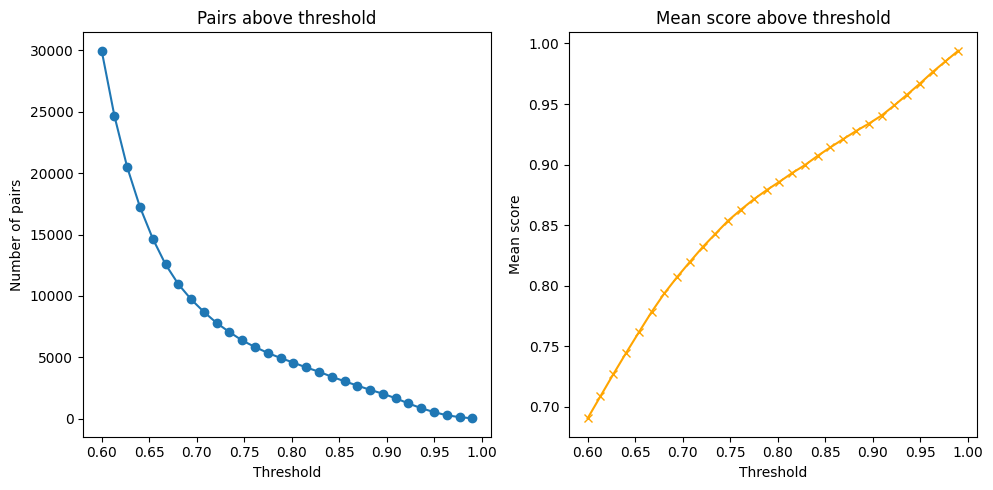

In [ ]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
mean_scores = []

for threshold in thresholds:
    mask = sim_scores > threshold
    i_indices = triu_indices[0][mask].tolist()
    j_indices = triu_indices[1][mask].tolist()
    scores = sim_scores[mask].tolist()
    similar_pairs = [(i, j, score) for i, j, score in zip(i_indices, j_indices, scores)]
    pair_counts.append(len(similar_pairs))
    mean_scores.append(np.mean(scores) if scores else 0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_scores[-1]}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(thresholds, pair_counts, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Number of pairs')
plt.title('Pairs above threshold')

plt.subplot(1, 2, 2)
plt.plot(thresholds, mean_scores, marker='x', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Mean score')
plt.title('Mean score above threshold')

plt.tight_layout()
plt.show()

In [21]:
def group_similar_pairs(similar_pairs):
    """Group pairs into connected components"""
    from collections import defaultdict
    
    graph = defaultdict(set)
    for i, j, score in similar_pairs:
        graph[i].add(j)
        graph[j].add(i)
    
    visited = set()
    groups = []
    
    def dfs(node, current_group):
        if node in visited:
            return
        visited.add(node)
        current_group.add(node)
        for neighbor in graph[node]:
            dfs(neighbor, current_group)
    
    for node in graph:
        if node not in visited:
            current_group = set()
            dfs(node, current_group)
            if current_group:
                groups.append(current_group)
    
    return groups

# Group the similar innovations
innovation_groups = group_similar_pairs(similar_pairs)
print(f"Found {len(innovation_groups)} groups of similar innovations")

# Show sample groups
for i, group in enumerate(innovation_groups[:3]):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  {innovations_dedup.iloc[idx]['source english_id']}")

Found 632 groups of similar innovations

Group 1 (size: 12):
  FiR 1
  FiR 1 -tutkimusreaktorin käytöstä poisto
  FiR1-ydinreaktorin purkuprojekti
  FiR1-ydinreaktori
  FiR 1 -tutkimusreaktori
  FiR1 reactor decommissioning project
  First nuclear decommissioning project in Finland at FiR1 reactor
  FiR1 nuclear reactor decommissioning
  FiR1 research nuclear reactor decommissioning
  FiR 1 -tutkimusreaktori
  FiR1 research nuclear reactor decommissioning project
  decommissioning the FiR1 research nuclear reactor

Group 2 (size: 2):
  AARRE project
  AARRE-projekti

Group 3 (size: 6):
  bio-based packaging solution made of cellulose
  bio-based packaging solution
  biodegradable packaging materials based on a fibrous web
  transparent cellulose film
  transparent cellulose film
  Transparent cellulose film by VTT


In [38]:
def get_all_organizations_for_innovation_group(group_indices, innovations_dedup, df_combined):
    """Get all organizations involved with an innovation group from the full dataset"""
    
    # Get all innovation names in this group
    innovation_names = []
    for idx in group_indices:
        innovation_names.append(innovations_dedup.iloc[idx]['source english_id'])
    
    # Get document numbers where these innovations appear
    innovation_docs = df_combined[
        df_combined['source english_id'].isin(innovation_names)
    ]['Document number'].unique()
    
    # Find ALL relationships from these documents (both Innovation and Organization sources)
    all_relationships = df_combined[
        df_combined['Document number'].isin(innovation_docs)
    ]
    
    # Organize organizations by their roles
    organizations = {}
    
    for _, row in all_relationships.iterrows():
        # Handle DEVELOPED_BY relationships (Innovation -> Organization)
        if (row['relationship type'] == 'DEVELOPED_BY' and 
            row['source english_id'] in innovation_names):
            
            target_id = row['target id']
            target_name = row['target english_id']
            
            if target_id not in organizations:
                organizations[target_id] = {
                    'name': target_name,
                    'developed_by': False,
                    'collaboration': False,
                    'mentions': []
                }
            
            organizations[target_id]['developed_by'] = True
            organizations[target_id]['mentions'].append({
                'innovation_name': row['source english_id'],
                'relationship_type': 'DEVELOPED_BY',
                'document_number': row['Document number']
            })
        
        # Handle COLLABORATION relationships (Organization -> Organization)
        elif row['relationship type'] == 'COLLABORATION':
            # Add both source and target organizations as collaborators
            for org_id, org_name in [(row['source id'], row['source english_id']), 
                                   (row['target id'], row['target english_id'])]:
                
                if org_id not in organizations:
                    organizations[org_id] = {
                        'name': org_name,
                        'developed_by': False,
                        'collaboration': False,
                        'mentions': []
                    }
                
                organizations[org_id]['collaboration'] = True
                organizations[org_id]['mentions'].append({
                    'innovation_context': f"Document {row['Document number']}",
                    'relationship_type': 'COLLABORATION',
                    'document_number': row['Document number']
                })
    
    return organizations

def create_unified_innovations(innovation_groups, innovations_dedup, df_combined):
    """Create final unified innovation records"""
    
    unified_innovations = []
    
    for group_idx, group in enumerate(innovation_groups):
        if len(group) == 1:  # Single innovation, not a duplicate group
            continue
            
        # Get canonical innovation (longest description)
        group_list = list(group)
        canonical_idx = max(group_list, 
                          key=lambda x: len(innovations_dedup.iloc[x]['source description'] or ''))
        canonical = innovations_dedup.iloc[canonical_idx]
        
        # Get all organizations involved with this innovation group
        organizations = get_all_organizations_for_innovation_group(group, innovations_dedup, df_combined)
        
        # Separate developers and collaborators
        developers = [org for org_id, org in organizations.items() if org['developed_by']]
        collaborators = [org for org_id, org in organizations.items() if org['collaboration']]
        
        # FIXED: Determine VTT's role(s) properly
        vtt_org = organizations.get('FI26473754', {})
        vtt_roles = []
        if vtt_org.get('developed_by', False):
            vtt_roles.append('developer')
        if vtt_org.get('collaboration', False):
            vtt_roles.append('collaborator')
        
        unified = {
            'group_id': f"innovation_group_{group_idx}",
            'canonical_name': canonical['source english_id'] + " **TEST_MODIFIED**",  # Debug text
            'canonical_description': canonical['source description'],
            'aliases': [innovations_dedup.iloc[idx]['source english_id'] for idx in group],
            'total_mentions': len(group),
            'developers': developers,
            'collaborators': collaborators,
            'vtt_role': '+'.join(vtt_roles) if vtt_roles else 'unknown',  # FIXED
            'document_numbers': list(set([mention['document_number'] for org in organizations.values() for mention in org['mentions']])),
            'debug_test': "FUNCTION_WAS_EXECUTED"  # Debug field
        }
        
        unified_innovations.append(unified)
    
    return unified_innovations

# Create the final unified innovations
unified_innovations = create_unified_innovations(innovation_groups, innovations_dedup, df_combined)
print(f"Created {len(unified_innovations)} unified innovation records")

Created 632 unified innovation records


In [37]:
import json

# Save results
with open('data/results/unified_innovations.json', 'w') as f:
    json.dump(unified_innovations, f, indent=2)

# Display sample results
print("\nSample Unified Innovations:")
for innovation in unified_innovations[:3]:
    print(f"\n{'='*60}")
    print(f"Innovation: {innovation['canonical_name']}")
    print(f"Aliases: {innovation['aliases']}")
    print(f"VTT Role: {innovation['vtt_role']}")
    print(f"Developers: {[dev['name'] for dev in innovation['developers']]}")
    print(f"Collaborators: {[collab['name'] for collab in innovation['collaborators']]}")
    print(f"Total mentions: {innovation['total_mentions']}")

# Create final clean dataset
final_df = pd.DataFrame(unified_innovations)
final_df.to_csv('data/results/vtt_unified_innovations.csv', index=False)
print(f"\nSaved {len(final_df)} unified innovations to CSV")


Sample Unified Innovations:

Innovation: FiR1-ydinreaktorin purkuprojekti **TEST_MODIFIED**
Aliases: ['FiR 1', 'FiR1 nuclear reactor decommissioning', 'First nuclear decommissioning project in Finland at FiR1 reactor', 'FiR1 research nuclear reactor decommissioning', 'FiR1 research nuclear reactor decommissioning project', 'decommissioning the FiR1 research nuclear reactor', 'FiR1 reactor decommissioning project', 'FiR 1 -tutkimusreaktori', 'FiR1-ydinreaktorin purkuprojekti', 'FiR1-ydinreaktori', 'FiR 1 -tutkimusreaktorin käytöstä poisto', 'FiR 1 -tutkimusreaktori']
VTT Role: developer
Developers: ['VTT Technical Research Centre of Finland Ltd.', 'Fortum', 'Delete Demolition Oy', 'Sweco Oy']
Collaborators: []
Total mentions: 12

Innovation: AARRE-projekti **TEST_MODIFIED**
Aliases: ['AARRE-projekti', 'AARRE project']
VTT Role: developer
Developers: ['VTT', 'Lassila & Tikanoja', 'Destaclean', 'Kierrätysverkko', 'CoreOrient', 'Eurokangas', 'Not Innovated Here', 'Chemical Industry Feder

# Let's group the pairs

In [7]:
def group_similar_pairs(similar_pairs):
    """
    Group pairs that share elements into connected components.
    
    Args:
        similar_pairs: List of tuples (i, j, score) where i and j are indices
                      and score is the similarity score
    
    Returns:
        List of groups, where each Egroup is a set of indices
    """
    from collections import defaultdict
    
    # Create adjacency list representation
    graph = defaultdict(set)
    
    # Build the graph from pairs
    for i, j, score in similar_pairs:
        graph[i].add(j)
        graph[j].add(i)
    
    # Find connected components using DFS
    visited = set()
    groups = []
    
    def dfs(node, current_group):
        if node in visited:
            return
        visited.add(node)
        current_group.add(node)
        
        # Visit all neighbors
        for neighbor in graph[node]:
            dfs(neighbor, current_group)
    
    # Find all connected components
    for node in graph:
        if node not in visited:
            current_group = set()
            dfs(node, current_group)
            if current_group:  # Only add non-empty groups
                groups.append(current_group)
    
    return groups

# Example usage:
groups = group_similar_pairs(similar_pairs)

# Print total number of groups
print(f"Total number of groups: {len(groups)}")

# Sort groups by size (largest first) for better display
groups_sorted = sorted(groups, key=len, reverse=True)

# Display first 5 groups with their texts
print(f"\nSample of first 5 groups:")
for i, group in enumerate(groups_sorted[:5]):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):  # Sort indices for consistent display
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")

Total number of groups: 637

Sample of first 5 groups:

Group 1 (size: 55):
  Index 1616: FI10410900 - UPM BioVerno is a renewable diesel fuel developed by UPM that works as well as regular ...
  Index 1617: FI10410900 - UPM BioVerno diesel is a bio-based diesel fuel tested to work equivalently to regular d...
  Index 1618: FI10410900 - UPM BioVerno is UPM's innovative renewable diesel fuel made from residues of the forest...
  Index 1619: FI10410900 - Renewable diesel fuel produced by UPM Biofuels that significantly reduces tailpipe emis...
  Index 1620: UPM BioVerno biofuel - A wood-based biofuel developed by UPM that has been proven to reduce carbon d...
  Index 1621: FI10410900 - A company that developed the wood-based biofuel UPM BioVerno, aimed at reducing emissio...
  Index 1628: FI10410900 - Renewable diesel fuel made from Finnish wood-based raw material, developed by UPM, whic...
  Index 1629: FI10410900 - A wood-based renewable diesel developed by UPM for use in buses in Hels